In [2]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import json
import requests
import seaborn as sns
import xgboost as xgb
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from scipy.stats import chi2_contingency
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from flask import Flask


In [44]:
def jupyter_settings():
    # Inline plotting
    %matplotlib inline
    # %pylab inline

    # Matplotlib settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    # Display settings
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None #Allows displaying all columns of a DataFrame.
    pd.options.display.max_rows = None # Allows displaying all rows of a DataFrame
    pd.set_option( 'display.expand_frame_repr', False ) #Prevents the DataFrame from being truncated when printed.

    # Seaborn settings
    sns.set() #Applies the default Seaborn style to plots.
jupyter_settings()

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse }, index=[0] )

# model_name: A string representing the name of the model being evaluated.
# y: The true values (actual values) of the target variable.
# yhat: The predicted values generated by the model.
# MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It is the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.
# MAPE measures the size of the error in percentage terms. It is the average of the absolute percentage errors of the predictions.
# RMSE measures the square root of the average squared differences between prediction and actual observation. It is a good measure of how accurately the model predicts the response and is the most important criterion for fit in many cases.

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    # Lists to store performance metrics
    mae_list = []
    mape_list = []
    rmse_list = []
    
    # Loop through each fold in reverse order
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Define start and end date for the validation set
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k - 1) * 6 * 7)
        
        # Split the data into training and validation sets
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # Prepare the training set (exclude 'date' and 'sales' columns)
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # Prepare the validation set (exclude 'date' and 'sales' columns)
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # Fit the model on the training data
        m = model.fit(xtraining, ytraining)
        
        # Predict on the validation data
        yhat = m.predict(xvalidation)
        
        # Calculate performance metrics (assuming ml_error function is defined elsewhere)
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Store performance metrics for the current fold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    # Return a DataFrame with the aggregated performance metrics
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

In [31]:
# Load the datasets
df5 = pd.read_csv( '../data/df5.csv', low_memory=False )
df5['date'] = pd.to_datetime(df5['date'])
df5['competition_since'] = pd.to_datetime(df5['competition_since'])
df5['promo_since'] = pd.to_datetime(df5['promo_since'])

In [32]:
df5_sorted=df5.sort_values(by='sales', ascending=True).sample(5)
df5_sorted

,store,day_ofyear,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week
230471,849,1,2014-11-17,6596,0,regular_day,0,c,extended,5000.0,...,2014,11,17,47,2014-46,2014-11-01,0,2014-11-17,0,1
647024,532,5,2013-08-02,9987,1,regular_day,1,a,extended,1070.0,...,2013,8,2,31,2013-30,2010-08-01,36,2013-07-29,0,5
779165,409,1,2013-03-11,3606,0,regular_day,0,d,extended,840.0,...,2013,3,11,11,2013-10,2013-03-01,0,2012-12-31,10,1
408117,754,2,2014-04-15,11474,1,regular_day,0,c,extended,380.0,...,2014,4,15,16,2014-15,2008-05-01,72,2014-03-03,6,2
390158,790,3,2014-05-07,7248,1,regular_day,0,d,extended,9070.0,...,2014,5,7,19,2014-18,2003-12-01,127,2014-05-05,0,3


# Data Preparation

## Normalization

## Rescaling

In [60]:
# Instantiate the scalers
rs = RobustScaler()
mms = MinMaxScaler()

# Apply RobustScaler to 'competition_distance' column
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# Save the RobustScaler for 'competition_distance'
with open('../parameter/robust_scaler_competition_distance.pkl', 'wb') as file:
    pickle.dump(rs, file)


# Apply RobustScaler to 'competition_time_month' column
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# Save the RobustScaler for 'competition_time_month'
with open('../parameter/robust_scaler_competition_time_month.pkl', 'wb') as file:
    pickle.dump(rs, file)


# Apply MinMaxScaler to 'promo_time_week' column
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# Save the MinMaxScaler for 'promo_time_week'
with open('../parameter/minmax_scaler_promo_time_week.pkl', 'wb') as file:
    pickle.dump(mms, file)


# Apply MinMaxScaler to 'year' column
df5['year'] = mms.fit_transform(df5[['year']].values)
# Save the MinMaxScaler for 'year'
with open('../parameter/minmax_scaler_year.pkl', 'wb') as file:
    pickle.dump(mms, file)


# Scaling in Data Preprocessing

Scaling is an essential step in data preprocessing, especially when dealing with features that have different scales or units. It ensures that no single feature dominates others due to its scale. In this context, two types of scalers are used: `RobustScaler` and `MinMaxScaler`.

## Scalers Used

### RobustScaler

- **Purpose**: This scaler removes the median and scales the data according to the interquartile range (IQR). It is particularly effective in handling outliers.
- **Application**:
  - `competition_distance`
  - `competition_time_month`
- **Reason for Use**: Features like `competition_distance` and `competition_time_month` might have significant outliers or varying ranges. `RobustScaler` helps in mitigating the impact of outliers, providing a more robust scaling.

### MinMaxScaler

- **Purpose**: This scaler transforms features by scaling each feature to a given range, typically [0, 1]. It preserves the relationships between data points by maintaining the relative distances between them.
- **Application**:
  - `promo_time_week`
  - `year`
- **Reason for Use**: Features like `promo_time_week` and `year` likely do not have significant outliers and benefit from being normalized to a standard range for better comparability and performance in machine learning algorithms.


# Transformation

## Encoding

In [34]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Save the LabelEncoder instance
with open('../parameter/label_encoder_store_type.pkl', 'wb') as file:
    pickle.dump(le, file)

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

# Explanation and Interpretation of Encoding Techniques

Encoding categorical variables is a critical step in data preprocessing, enabling machine learning models to interpret and utilize these features effectively. Let's break down each encoding technique used and interpret their implications.

## One Hot Encoding for `state_holiday`

### Explanation:
- **One Hot Encoding**: This technique converts categorical variables into a set of binary (0 or 1) columns. Each column represents a unique category from the original variable.

### Interpretation:
- **Advantage**: This technique avoids ordinal relationships between categories that do not have an intrinsic order. Each category is treated independently.
- **Implication**: The resulting DataFrame has new binary columns representing the presence (1) or absence (0) of each state holiday. This allows the machine learning model to understand and process the categorical information effectively.

## Label Encoding for `store_type`

### Explanation:
- **Label Encoding**: This technique converts categorical text data into numerical data by assigning a unique integer to each category.

### Interpretation:
- **Advantage**: Simple and quick conversion of categorical text data to numerical form.
- **Implication**: Each category is now represented by a unique integer. However, this method introduces an ordinal relationship where the model might incorrectly interpret higher integers as higher importance, which may not be the case for all categorical data.

## Ordinal Encoding for `assortment`

### Explanation:
- **Ordinal Encoding**: This technique is used for categorical variables where the categories have a meaningful order or ranking.

### Interpretation:
- **Advantage**: This method preserves the intrinsic order or ranking among categories.
- **Implication**: The `assortment` column is now represented by integers that reflect the intended ranking or importance. This is crucial when the order of categories matters for the analysis or model interpretation.

## Summary

By applying these encoding techniques, the categorical variables in the dataset are transformed into numerical formats suitable for machine learning models. Here's a quick summary of their impact:

- **One Hot Encoding for `state_holiday`**: Each category is treated independently, avoiding any unintended ordinal relationships.
- **Label Encoding for `store_type`**: Converts text categories to numerical form but may introduce unintended ordinal relationships.
- **Ordinal Encoding for `assortment`**: Converts categories to integers while preserving their meaningful order or ranking.

These transformations ensure that the machine learning models can interpret and process the categorical data accurately, leading to better performance and more meaningful insights.


## Response Variable Transformation

In [35]:
df5['sales']=np.log1p(df5['sales'])

### Log Transformation of Sales

Log transformation is a powerful technique used to stabilize the variance, make the data more normally distributed, and improve the performance of machine learning models. Here's an explanation and interpretation of applying the log transformation to the `sales` feature.

#### Explanation:
- **Log Transformation**: This technique involves applying the natural logarithm to each value in a feature. In this case, the transformation is applied using `np.log1p`, which is the natural logarithm of one plus the input array. This is useful to handle zero values effectively since `log(0)` is undefined.

#### Interpretation:
- **Advantage**:
  - **Variance Stabilization**: Log transformation helps stabilize the variance in data. This is particularly beneficial when the data spans several orders of magnitude.
  - **Normal Distribution**: It makes the data more normally distributed, which is an assumption for many statistical techniques and machine learning algorithms.
  - **Improved Model Performance**: Models like linear regression assume normally distributed residuals. Applying log transformation can improve the model's performance and accuracy by meeting this assumption.

- **Implication**:
  - **Sales Feature**: The `sales` feature is now transformed using the natural logarithm. Each sales value is represented on a logarithmic scale, reducing the skewness of the distribution and making the data more amenable to modeling.
  - **Back Transformation**: When interpreting the model's predictions, remember to apply the exponential function to revert the log transformation (`np.expm1`), ensuring the results are in the original scale.

By applying this transformation, the `sales` feature becomes more normally distributed, facilitating better model training and more reliable predictions.


# Nature Transformation

In [67]:
# Day of Week Transformation
# Applying sine and cosine transformations to capture the cyclical nature of the week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# Month Transformation
# Applying sine and cosine transformations to capture the yearly seasonality
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# Day Transformation
# Applying sine and cosine transformations to capture the monthly periodicity
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# Week of Year Transformation
# Applying sine and cosine transformations to capture the yearly periodicity
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

## Nature transformation leverages trigonometric functions to capture cyclical patterns in time-related features. By applying sine and cosine transformations, we can model periodicity and seasonality effectively. Here's how we applied these transformations to the `day_of_week`, `month`, `day`, and `week_of_year` features.

# Featuring Selection

In [37]:
df6=df5.copy()

## Split dataframe into training and test dataset

In [38]:
# List of columns to be dropped
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

# Drop the specified columns from the DataFrame
df6 = df6.drop(cols_drop, axis=1)

# Group by 'store' and find the latest date for each store
latest_dates = df6.groupby('store')['date'].max().reset_index()

# Subtract 6 weeks (42 days) from the latest date for each store
latest_dates['date_minus_6_weeks'] = latest_dates['date'] - datetime.timedelta(days=6*7)

# Display the result
# print(latest_dates)

### Reasons for Dropping Each Specified Column

#### `week_of_year`:
- **Reason for Dropping**: This column have been dropped because its information is redundant or unnecessary for the analysis, the model already uses other time-related features like `date` or if the cyclical nature of the week is already captured by other features.

#### `day`:
- **Reason for Dropping**: The day of the month can introduce high cardinality without providing much useful information. Additionally, the cyclical nature of days in a month can be captured by sine and cosine transformations, which have already been applied.

#### `month`:
- **Reason for Dropping**: Similar to `day`, the month can be represented using sine and cosine transformations to capture its cyclical nature. Thus, the raw `month` column becomes redundant.

#### `day_of_week`:
- **Reason for Dropping**: The day of the week is another cyclical feature. If its cyclical nature is captured using sine and cosine transformations, the original column is no longer needed.

#### `promo_since`:
- **Reason for Dropping**: This column might contain the date since a promotion started, which can be converted into a numerical feature representing the duration of the promotion. Once converted, the original date information is redundant.

#### `competition_since`:
- **Reason for Dropping**: Similar to `promo_since`, this column likely contains the date since a competitor started affecting the store. Once this date information is converted into a numerical duration, the original date column can be dropped.

#### `year_week`:
- **Reason for Dropping**: This column is likely a combination of year and week information. If the cyclical nature of the year and week is already captured through other features or transformations, this combined feature may no longer be necessary.

### Summary
- **Redundancy**: Many of these columns might be redundant because their cyclical nature can be better captured through transformations (e.g., sine and cosine).
- **High Cardinality**: Features like `day` and `week_of_year` can introduce high cardinality, which can be problematic for some models.
- **Feature Engineering**: Columns like `promo_since` and `competition_since` can be converted into more informative numerical features representing durations, making the original columns redundant.

Dropping these columns helps in simplifying the DataFrame, reducing multicollinearity, and focusing on more informative features that better capture the underlying patterns in the data.

# Boruta

## Spliting data

In [39]:
# Split the dataset into training and test sets
# Training dataset: dates before '2015-06-19'
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset: dates on or after '2015-06-19'
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

# Print the date range for the training dataset
print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

# Print the date range for the test dataset
print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### Model Training

- **Purpose**: The training set is used to train the model, allowing it to learn patterns and relationships from historical data.
- **Chronological Order**: Ensuring the training set is chronologically ordered helps the model to capture time-dependent patterns.

### Model Evaluation

- **Purpose**: The test set is used to evaluate the model's performance on unseen data.
- **Real-World Scenario**: By splitting the data based on a specific cutoff date, we simulate a real-world scenario where the model makes predictions on future data.

### Preventing Data Leakage

- **Purpose**: Splitting the dataset based on a specific date ensures that future information does not influence the training process.
- **Impact**: Prevents overfitting and unrealistic performance estimates by ensuring that the model is only trained on past data.

### Ensuring Chronological Order

- **Importance**: In time series analysis, maintaining the chronological order of data is crucial.
- **Benefit**: This split ensures that the model is trained on past data and tested on future data, maintaining the temporal integrity of the dataset.

By following this approach, you can effectively prepare your dataset for time series forecasting or any other analysis that requires a chronological split between training and test data.


# Boruta

In [16]:

# # Prepare training data for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel() # This flattens the target variable y_train into a 1-dimensional array using ravel(). This is often necessary for compatibility with scikit-learn functions

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1) #use all cpu cores

# # Define Boruta 
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# # Fit Boruta
# boruta.fit(X_train_n, y_train_n) # This fits the Boruta model to the training data, determining which features are important.
# cols_selected = boruta.support_.tolist() # This retrieves a list of boolean values indicating which features were selected as important by Boruta.

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 ) #This again removes the date and sales columns from X_train but keeps the data in a DataFrame format.
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() #: This converts the list of boolean values into actual column names of the selected features.

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta )) #This determines the features that were not selected by Boruta by computing the set difference between all features and the selected features.

# print(cols_selected_boruta)
# print(cols_not_selected_boruta)

In [17]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_cos']

In [18]:
cols_not_selected_boruta = [
'is_promo',
'month_sin',
'school_holiday',
'state_holiday_christmas',
'state_holiday_easter_holiday',
'state_holiday_public_holiday',
'state_holiday_regular_day',
'week_of_year_sin',
'year',]

In [40]:
#manual selected compare with hypostheses analises 
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


In [41]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# Machine Learning Modeling

In [42]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]


In [22]:
# x_train
    # X_train = df6[df6['date'] < '2015-06-19']
    # x_train = X_train[ cols_selected_boruta ]  

# x_test
    # X_test = df6[df6['date'] >= '2015-06-19']
    # x_test = X_test[ cols_selected_boruta ]

# x_training
    # x_training = X_train[ cols_selected_boruta_full ]
    # feat_to_add = ['date', 'sales']
#y_test
    # # Test dataset: dates on or after '2015-06-19'
    # X_test = df6[df6['date'] >= '2015-06-19']
    # y_test = X_test['sales']


## Average Model

In [45]:
# Creating a DataFrame for the last 6 weeks for the boruta columns and adding 'date' and 'sales' from y_test
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

## prediction aux2 -> aux1 (using mean of sales)
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
# def ml_error( model_name, y, yhat ):
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result




,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## Linear Regression Model

In [24]:
# Training the Model
lr = LinearRegression().fit( x_train, y_train )

# Fitting the Model: The fit() method trains the model using the training data (x_train and y_train).
# x_train (df with boruta columns before 6 final weeks)
# y_train column sales before 6 final weeks

# Making Predictions
yhat_lr = lr.predict( x_test )
# Predicting: The predict() method uses the trained model to make predictions on the test data (x_test).
# lr: This is an instance of the LinearRegression class from scikit-learn. It represents a linear regression model that has already been trained using the fit() method with training data (x_train and y_train).
# Grouping by 'store' and calculating the mean sales for each store
# Renaming the 'sales' column to 'predictions' in the resulting DataFrame
# x_test: This is a DataFrame or array-like structure containing the test data. (last 6 weeks)

# Checking performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## linear regression has a RMSE higher than average, meaning the system is non linear and requires non linear methods. 

## Linear Regression Model - Cross Validation

In [25]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## Linear Regression Regularized Model - Lasso

In [26]:
# Training the Model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# Fitting the Model: The fit() method trains the model using the training data (x_train and y_train).
# x_train (df with boruta columns before 6 final weeks)
# y_train column sales before 6 final weeks

# Making Predictions
yhat_lrr = lrr.predict( x_test )
# Predicting: The predict() method uses the trained model to make predictions on the test data (x_test).
# lr: This is an instance of the LinearRegression class from scikit-learn. It represents a linear regression model that has already been trained using the fit() method with training data (x_train and y_train).
# Grouping by 'store' and calculating the mean sales for each store
# Renaming the 'sales' column to 'predictions' in the resulting DataFrame
# x_test: This is a DataFrame or array-like structure containing the test data. (last 6 weeks)

# Checking performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1(yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## again RMSE is higher meaning is not linear

## Linear Regression Model - Cross Validation

In [27]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## Random Forest Regressor

In [28]:

# Training the Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )
# good RF have 2500 - 3000 estimators
# Making Predictions
yhat_rf = rf.predict( x_test )
# Checking performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.388728,0.099899,1010.742195


# Random Forest Regressor - Cross Validation

In [29]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
# rf_result_cv

# XGBoost Regressor

In [30]:
# Training the Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=300,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytree=0.9 ).fit( x_train, y_train )

# Making Predictions
yhat_xgb = model_xgb.predict( x_test )

# Checking performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1367.023756,0.199689,2004.493719


## XGBoost Regressor - Cross Validation

In [31]:
# gb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
# xgb_result_cv

## Compare Model’s Performance

### Single Performance

In [32]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.388728,0.099899,1010.742195
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1367.023756,0.199689,2004.493719
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


# this not represent the final veredict, because its only over the last 6 weeks. Need to be tested over a wider range of data to ensure fitness. Need to use cross validation for that.

### Real Performance - Cross Validation

In [33]:
# modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
# modelling_result_cv

# HYPERPARAMETER FINE TUNING

- **Random Search** is more efficient than grid search for large spaces and can find good hyperparameters faster.
- **Grid Search** is exhaustive but computationally expensive and feasible for small hyperparameter spaces.
- **Bayesian Optimization** is the most advanced, focusing on promising regions of the space and often finding optimal hyperparameters with fewer iterations, but it is more complex and resource-intensive.


## Random Search

In [34]:
#param = {
    # 'n_estimators': [1500, 1700, 2500, 3000, 3500],
    # 'eta': [0.01, 0.03],
    # 'max_depth': [3, 5, 9],
    # 'subsample': [0.1, 0.5, 0.7],
    # 'colsample_bytree': [0.3, 0.7, 0.9],
    # 'min_child_weight': [3, 8, 15]
# }
#
#MAX_EVAL = 5

In [35]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
    # # choose values for parameters randomly
    # hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    # print( hp )
        
    # # model
    # model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
    # n_estimators=hp['n_estimators'],
    # eta=hp['eta'],
    # max_depth=hp['max_depth'],
    # subsample=hp['subsample'],
    # colsample_bytee=hp['colsample_bytree'],
    # min_child_weight=hp['min_child_weight'] 
    
    # # performance
    # result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,␣֒→verbose=True )
    # final_result = pd.concat( [final_result, result] )
#
#final_result

## Final Model

In [46]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
    }

In [47]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=param_tuned['n_estimators'],
eta=param_tuned['eta'],
max_depth=param_tuned['max_depth'],
subsample=param_tuned['subsample'],
colsample_bytree=param_tuned['colsample_bytree'],
min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,777.043668,0.116216,1123.594037


In [48]:
# Save the trained model to a file
with open('../model/model_rossmann.pkl', 'wb') as file:
    pickle.dump(model_xgb_tuned, file)

### Compare with status quo and business metrics like revenue forecast

# Error Analysis

In [38]:
# Create a new DataFrame df9 from selected columns in X_test
df9 = X_test[cols_selected_boruta_full].copy()

# Rescale 'sales' and assign to the DataFrame
df9.loc[:, 'sales'] = np.expm1(df9['sales'])

# Rescale 'predictions' and assign to the DataFrame
df9.loc[:, 'predictions'] = np.expm1(yhat_xgb_tuned)


## Business Performance


In [40]:
# Sum of predictions
# Grouping by 'store' and summing the 'predictions' column, then resetting the index for a clean DataFrame
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# Calculate MAE (Mean Absolute Error)
# Grouping by 'store' and applying the mean_absolute_error function to calculate the MAE for each store
df9_aux1 = df9.groupby('store', group_keys=False).apply(
                                                        lambda x: mean_absolute_error(x['sales'], x['predictions']),include_groups=False).reset_index().rename(columns={0: 'MAE'})

# Calculate MAPE (Mean Absolute Percentage Error)
# Grouping by 'store' and applying the mean_absolute_percentage_error function to calculate the MAPE for each store
df9_aux2 = df9.groupby('store', group_keys=False).apply(
                                                        lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']),include_groups=False).reset_index().rename(columns={0: 'MAPE'})

# Merge MAE and MAPE results
# Merging the two DataFrames (MAE and MAPE) on the 'store' column
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')

# Merge the sum of predictions with MAE and MAPE results
# Merging the sum of predictions DataFrame (df91) with the combined MAE and MAPE DataFrame (df9_aux3) on the 'store' column
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Calculate scenarios
# Calculating the worst case scenario by subtracting MAE from predictions
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
# Calculating the best case scenario by adding MAE to predictions
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
# Reordering the columns of the final DataFrame for better readability
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

# Display the final DataFrame
# Printing the final DataFrame to view the results
print(df92)


      store    predictions  worst_scenario  best_scenario          MAE      MAPE
0         1  172346.890625   171951.038535  172742.742715   395.852090  0.090044
1         2  184567.968750   184107.578739  185028.358761   460.390011  0.093628
2         3  266553.906250   265902.995526  267204.816974   650.910724  0.089955
3         4  337803.156250   336827.346152  338778.966348   975.810098  0.092741
4         5  169926.765625   169573.570695  170279.960555   353.194930  0.077026
5         6  183452.046875   182951.823414  183952.270336   500.223461  0.111410
6         7  339069.562500   338159.265493  339979.859507   910.297007  0.090982
7         8  202549.437500   201633.398134  203465.476866   916.039366  0.132454
8         9  264955.968750   264341.406039  265570.531461   614.562711  0.081152
9        10  206248.453125   205585.905570  206911.000680   662.547555  0.113408
10       11  288458.468750   287820.633222  289096.304278   637.835528  0.089223
11       12  281455.937500  

In [41]:
# Display the top stores with the highest MAPE
# Sorting the DataFrame by MAPE in descending order and displaying the top rows
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105687.914062,102281.250450,109094.577675,3406.663613,0.593064
908,909,220616.468750,212672.715778,228560.221722,7943.752972,0.522000
594,595,323519.968750,317960.697318,329079.240182,5559.271432,0.383606
901,902,199952.734375,198546.119932,201359.348818,1406.614443,0.351834
875,876,197488.328125,193470.734067,201505.922183,4017.594058,0.323056


<Axes: xlabel='store', ylabel='MAPE'>

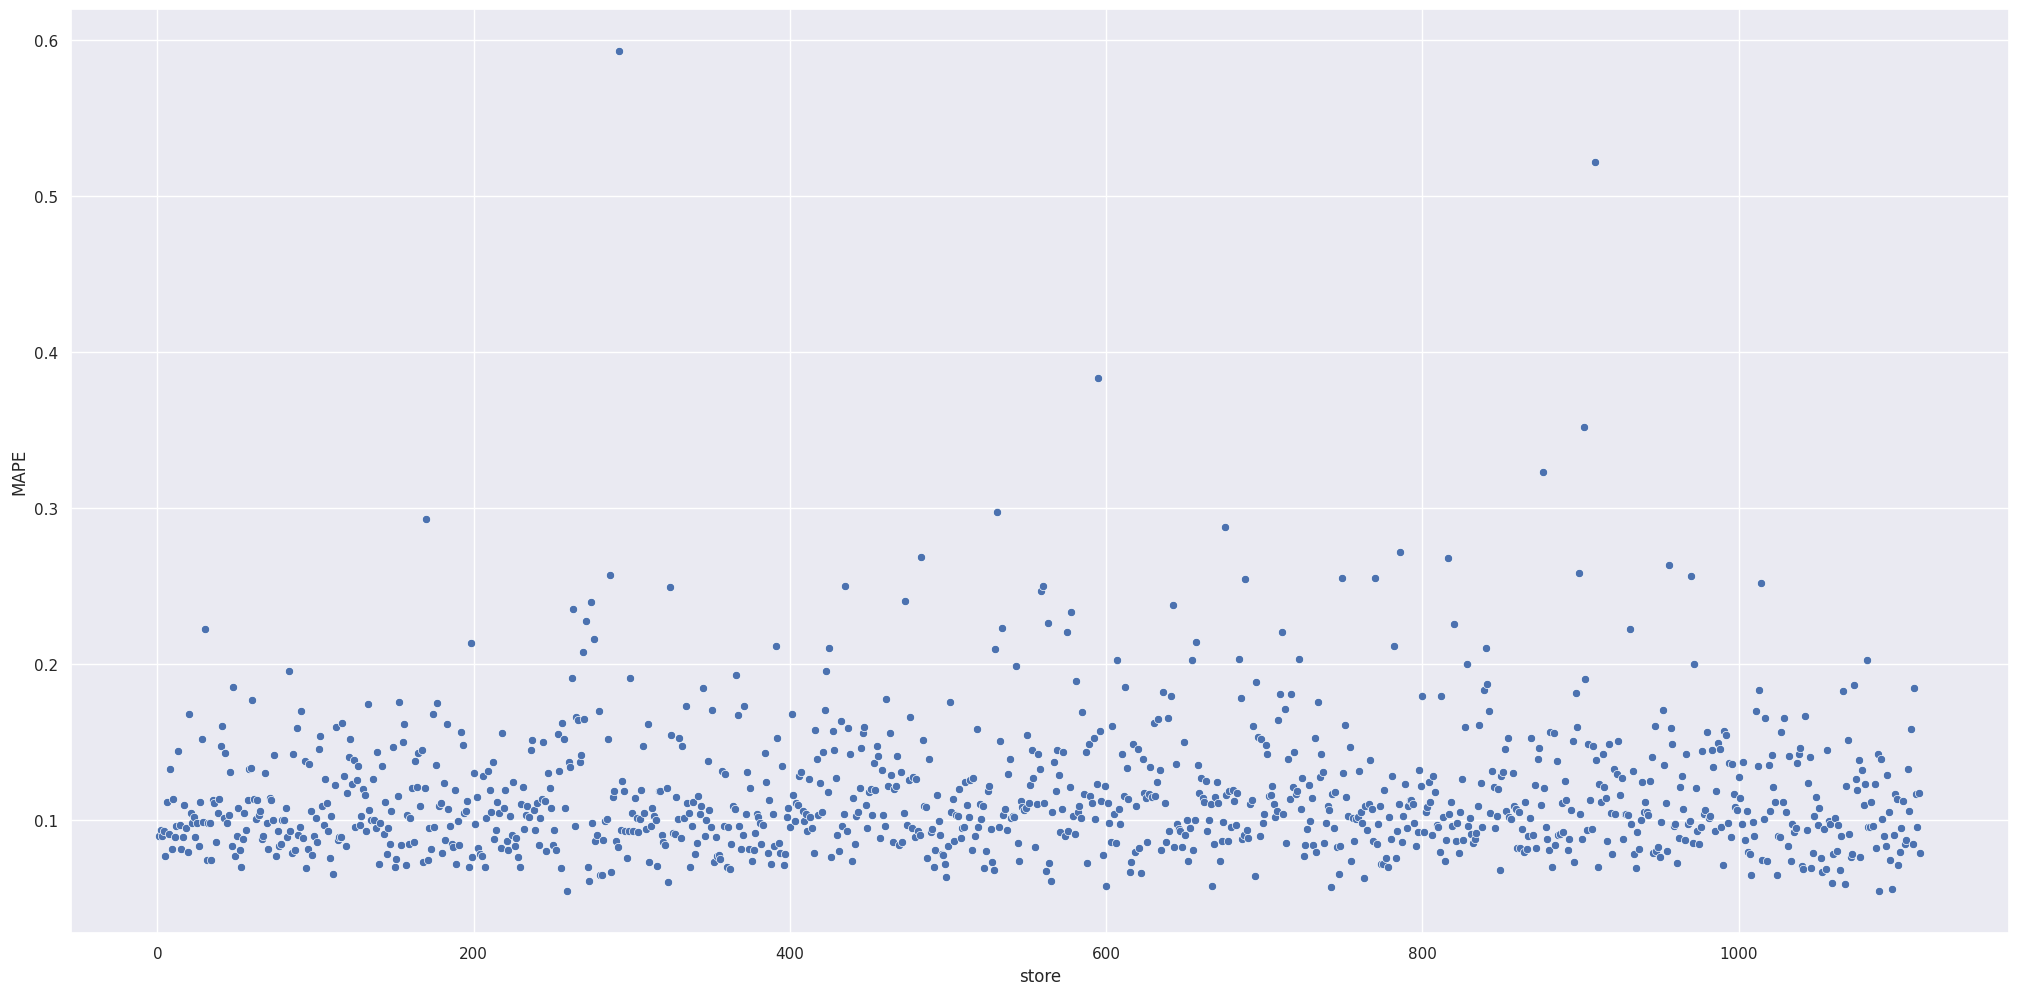

In [42]:
# Plotting a scatter plot
# Creating a scatter plot to visualize the relationship between 'store' and 'MAPE' using Seaborn
sns.scatterplot(x='store', y='MAPE', data=df92)

### Interpretation of the Scatter Plot

#### Error Distribution:
The scatter plot shows that the majority of stores have a MAPE between 10% and 20%, indicating that the predictions are generally within 10% to 20% of the actual sales values.

#### Outliers:
There are several stores with a MAPE significantly higher than 20%, which suggests that predictions for these stores are less accurate and more challenging. These outliers could be due to various factors such as unique store characteristics, inconsistent sales patterns, or insufficient data.

#### Business Implications:
- **Focus on High MAPE Stores:** Stores with high MAPE values may require closer examination to understand the underlying causes of prediction inaccuracies. This could involve investigating unique store attributes, promotional activities, local market conditions, or data quality issues.
- **Improving Prediction Models:** For stores with consistently high errors, it may be beneficial to enhance the prediction models by incorporating additional features, using more advanced algorithms, or adjusting for seasonality and other temporal effects.
- **Resource Allocation:** Understanding which stores have higher prediction errors can help in better resource allocation. For instance, more accurate predictions can lead to optimized inventory management, while less accurate predictions may require more buffer stock to mitigate the risk of stockouts.


##  Total Performance

In [43]:
# Aggregating predictions and scenarios
# Selecting the columns 'predictions', 'worst_scenario', and 'best_scenario' from df92
# Applying the sum function along the rows (axis=0) to aggregate the values
# Resetting the index to convert the Series to a DataFrame
# Renaming the columns for better readability
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(
                                                                        lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})

# Formatting the 'Values' column
# Mapping the 'Values' column to a string format with currency representation 'R${:,.2f}'
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)

# Displaying the final DataFrame
# Printing df93 to view the aggregated and formatted results
df93


,Scenario,Values
0,predictions,"R$286,018,880.00"
1,worst_scenario,"R$285,149,419.25"
2,best_scenario,"R$286,888,364.56"


### Business Implications:

#### Strategic Planning:
- The aggregated values give a comprehensive view of the overall sales forecast, aiding in strategic planning and decision-making.
- It helps in setting realistic targets and benchmarks for performance evaluation.

#### Risk Management:
- Understanding the worst-case scenario allows businesses to plan for potential downturns, ensuring they have adequate measures in place.
- This can include adjusting inventory levels, preparing contingency plans, and managing financial expectations.

#### Opportunity Maximization:
- The best-case scenario highlights the potential for exceeding sales targets.
- This can encourage businesses to capitalize on opportunities by investing in marketing, promotions, and other growth initiatives.

#### Resource Allocation:
- With clear insights into potential sales ranges, businesses can allocate resources more effectively.
- This includes budgeting, staffing, and inventory management to ensure alignment with forecasted sales volumes.


## Machine Learning Performance

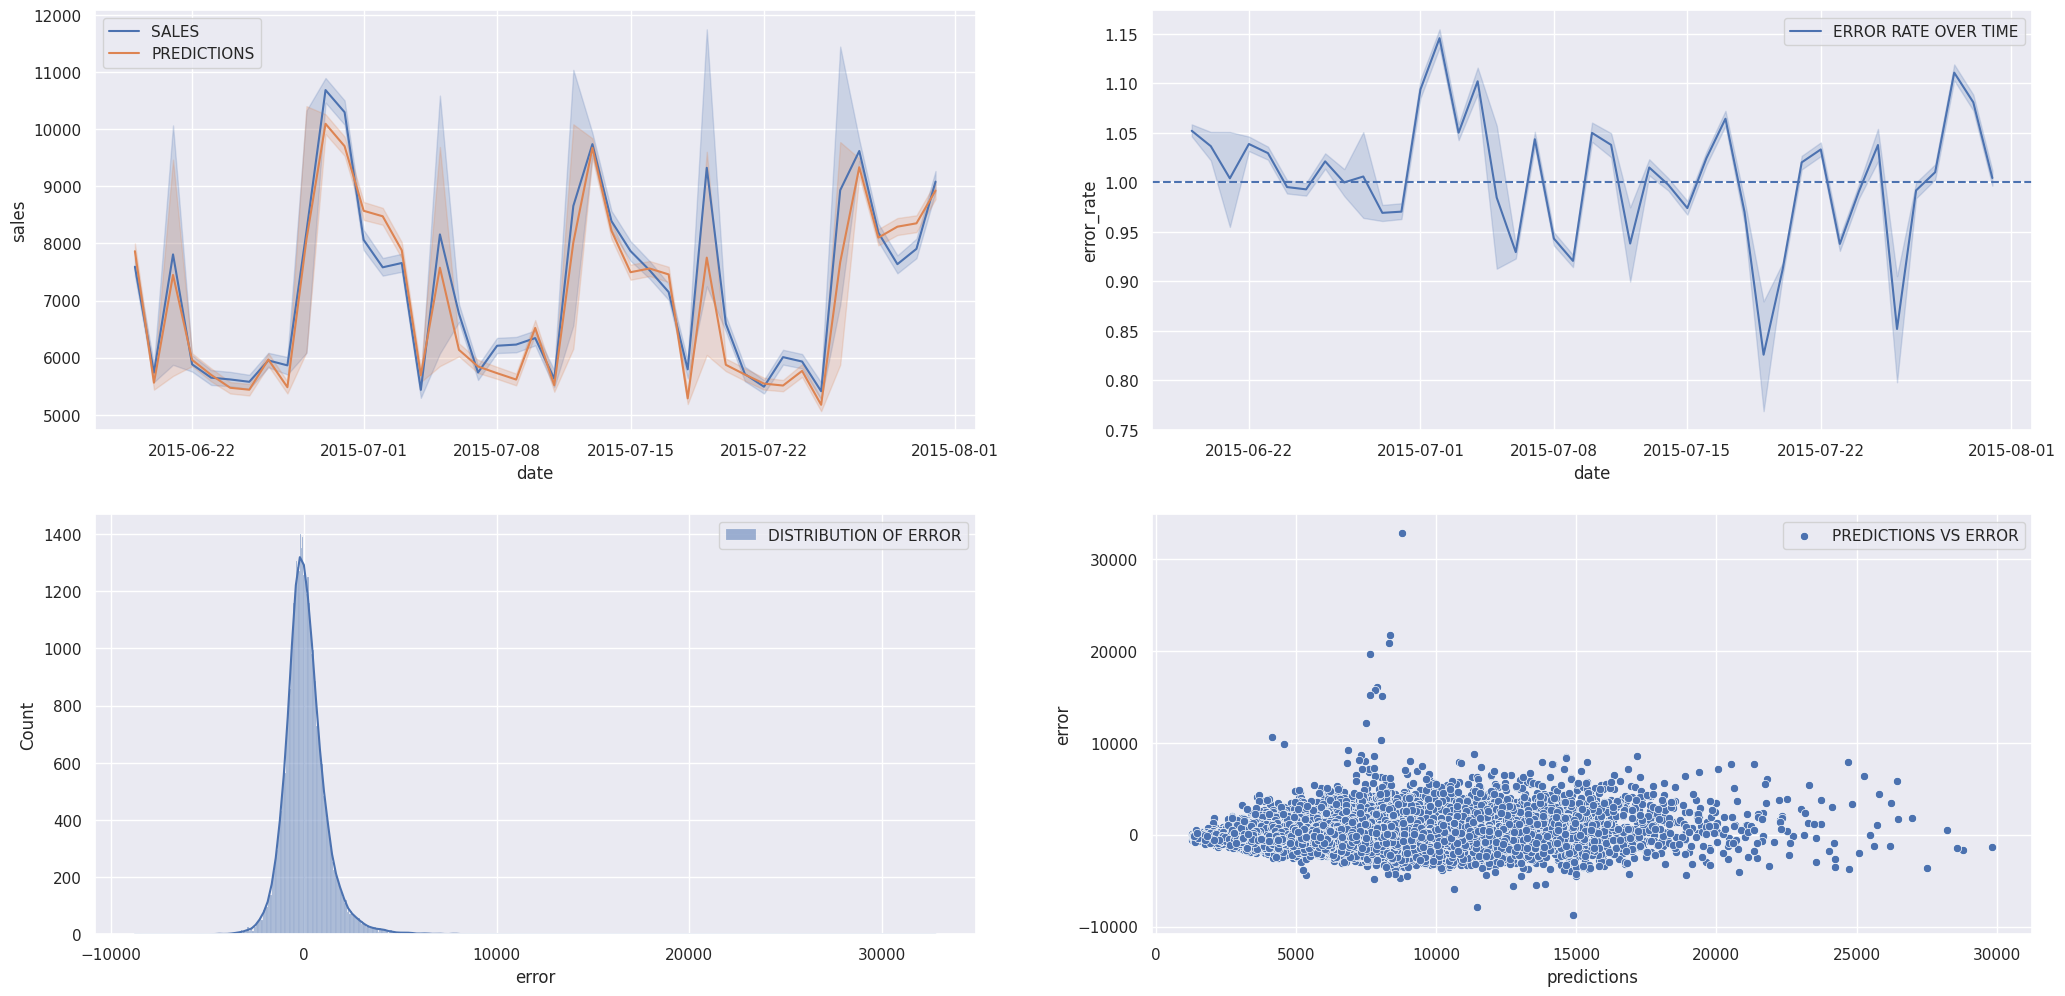

In [44]:
# Calculate error and error rate
# Adding a new column 'error' to df9 which is the difference between 'sales' and 'predictions'
df9['error'] = df9['sales'] - df9['predictions']

# Adding a new column 'error_rate' to df9 which is the ratio of 'predictions' to 'sales'
df9['error_rate'] = df9['predictions'] / df9['sales']

# Create subplots
# Creating a subplot with 2 rows and 2 columns for different plots
plt.subplot(2, 2, 1)

# Plot sales and predictions over time
# Plotting a line plot of 'sales' over 'date' with a label 'SALES'
sns.lineplot(x='date', y='sales', data=df9, label='SALES')

# Plotting a line plot of 'predictions' over 'date' with a label 'PREDICTIONS'
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

# Create the second subplot
plt.subplot(2, 2, 2)

# Plot error rate over time
# Plotting a line plot of 'error_rate' over 'date'
sns.lineplot(x='date', y='error_rate', data=df9, label='ERROR RATE OVER TIME')

# Adding a horizontal line at y=1 with a dashed linestyle
plt.axhline(1, linestyle='--')

# Create the third subplot
plt.subplot(2, 2, 3)

# Plot distribution of errors
# Plotting the distribution of 'error' using a histogram and KDE
sns.histplot(df9['error'], kde=True, label='DISTRIBUTION OF ERROR')

# Display the legend
plt.legend()

# Create the fourth subplot
plt.subplot(2, 2, 4)

# Plot predictions vs. errors
# Creating a scatter plot of 'predictions' against 'error'
sns.scatterplot(x='predictions', y='error', label='PREDICTIONS VS ERROR', data=df9)

# Display the legend
plt.legend()

# Display the plots
plt.show()


# Business Analysis of Sales Predictions and Errors

## Chart 2,2,1: Sales and Predictions Over Time

**Interpretation:** The line plot shows both the actual sales and the predicted sales over time. The close alignment of the prediction line to the actual sales line indicates that the model's predictions are quite accurate. The shaded areas represent the range of values, showing the variability in predictions.

**Business Impact:** Accurate predictions enable better inventory management, staffing, and financial planning. The close fit suggests reliability in the model, which can be trusted for making business decisions.

## Chart 2,2,2: Error Rate Over Time

**Interpretation:** The error rate is plotted over time, where an error rate close to 1 indicates accurate predictions. Values above 1 indicate overestimation, and values below 1 indicate underestimation.

**Business Impact:** Monitoring the error rate helps identify periods where the model consistently overestimates or underestimates sales. This information can be used to adjust the model or investigate specific time periods for unusual trends or events affecting sales.

## Chart 2,2,3: Distribution of Error

**Interpretation:** The histogram with a KDE plot shows the distribution of prediction errors. The normal distribution suggests that most errors are centered around zero, with fewer large errors on either side.

**Business Impact:** A normal distribution of errors indicates that the model does not have systematic bias. This is advantageous as it means the model's errors are random and not skewed, leading to more reliable forecasts. Residual analysis helps in assessing model performance and diagnosing potential issues.

## Chart 2,2,4: Predictions vs. Error

**Interpretation:** The scatter plot shows the relationship between predictions and their corresponding errors. The "tube" shape with errors centered around zero indicates that predictions are consistently close to actual sales values.

**Business Impact:** The tight distribution of errors around zero suggests that the model performs well across different levels of sales, ensuring reliable predictions. This uniform error distribution is critical for maintaining confidence in the model across various scenarios.

## Overall Business Implications:

- **Strategic Planning:** The accurate and consistent performance of the prediction model aids in strategic planning and setting realistic sales targets.
- **Risk Management:** Understanding the distribution and nature of prediction errors helps in identifying potential risks and preparing contingency plans.
- **Resource Allocation:** Reliable predictions enable better allocation of resources such as inventory, staffing, and budget, optimizing overall business operations.
- **Continuous Improvement:** Regular monitoring and analysis of prediction errors facilitate continuous improvement of the model, ensuring sustained accuracy and reliability in forecasts.

By leveraging these insights, businesses can enhance their operational efficiency, minimize risks, and capitalize on growth opportunities effectively.


# Deploy Model to Production        

In [69]:
# Load the model from the file
with open('../model/model_rossmann.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

## Rossmann Class        

In [71]:
# Create Class: need to save the transformation in a pickle to apply the same transformation to new data incoming

class rossmann(object):
    def __init__(self):
        self.home_path='/home/thiago_souza/project_cds/rossmann_case/'
        # Load the RobustScaler for 'competition_distance'
        self.robust_scaler_competition_distance    = pickle.load(open(self.home_path +'parameter/robust_scaler_competition_distance.pkl', 'rb'))
    
        # Load the RobustScaler for 'competition_time_month'
        self.robust_scaler_competition_time_month  = pickle.load(open(self.home_path +'parameter/robust_scaler_competition_time_month.pkl', 'rb'))

        # Load the MinMaxScaler for 'promo_time_week'
        self.minmax_scaler_promo_time_week         = pickle.load(open(self.home_path +'parameter/minmax_scaler_promo_time_week.pkl', 'rb'))
        
        # Load the MinMaxScaler for 'year'
        self.minmax_scaler_year                    = pickle.load(open(self.home_path +'parameter/minmax_scaler_year.pkl', 'rb'))

        # Load the LabelEncoder for 'store_type'
        self.label_encoder_store_type              = pickle.load(open(self.home_path +'parameter/label_encoder_store_type.pkl', 'rb'))
    
    def data_cleanning(self, df1):
        # List of original column names removed columns customer and sales
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open',
                    'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        # Lambda function to convert camel case to snake case
        snakecase = lambda x: inflection.underscore( x )

        # Apply the function to each column name in cols_old
        cols_new = list( map( snakecase, cols_old ) )

        # Rename the columns of the DataFrame
        df1.columns = cols_new
        
        # Convert the 'date' column in df1 to datetime format
        df1['date']=pd.to_datetime(df1['date'])
        
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(
            lambda x:200000.0 if math.isnan( x ) else x )
        #Business Context: The chosen value (200000.0 in this case) is an assumptions. If the competition distance is unknown, is reasonable to assume it is very high, indicating no nearby competition.

        # Replace NaN values in 'competition_open_since_month' with the month from 'date'
        df1['competition_open_since_month'] = df1.apply(
            lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        #Replacing NaN values in the competition_open_since_month column with the month extracted from the date column is a pragmatic solution to ensure data completeness, maintain temporal consistency, and avoid biases, ultimately leading to more reliable and insightful business analyses and decisions.

        # Replace NaN values in 'competition_open_since_year' with the year from 'date'
        df1['competition_open_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # Replace NaN values in 'promo2_since_week' with the week from 'date'
        df1['promo2_since_week'] = df1.apply(
            lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # Replace NaN values in 'promo2_since_year' with the year from 'date'
        df1['promo2_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # Handle 'promo_interval' and create 'is_promo' flag
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        # df1 = df1.copy()  # Ensure we are working with a copy of the original DataFrame
        df1['promo_interval']=df1['promo_interval'].fillna(0)
        df1['month_map']=df1['date'].dt.month.map(month_map)
        df1['is_promo']=df1.apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        # Convert 'competition_open_since_month' column to integer type
        df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)

        # Convert 'competition_open_since_year' column to integer type
        df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)

        # Convert 'promo2_since_week' column to integer type
        df1['promo2_since_week']=df1['promo2_since_week'].astype(int)

        # Convert 'promo2_since_year' column to integer type
        df1['promo2_since_year']=df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(sel, df2):

        #Create year column
        df2['year']=df2['date'].dt.year

        #Create month column
        df2['month']=df2['date'].dt.month

        #Create year column
        df2['day']=df2['date'].dt.day

        #Create week of year column
        df2['week_of_year']=df2['date'].dt.isocalendar().week

        #Create year week column
        df2['year_week']=df2['date'].dt.strftime('%Y-%U')

        #Create competition since column
        df2['competition_since']=df2.apply(
                                            lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                        month=x['competition_open_since_month'],
                                                                        day=1), axis=1)

        df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(
                                                                                        lambda x: x.days).astype(int)

        #Create promo since column
        df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)

        df2['promo_since']=df2['promo_since'].apply(
                                                    lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w')-datetime.timedelta(days=7))

        #Create promo time week column
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(
                                                                                        lambda x: x.days).astype(int)

        #change assortment classification
        df2['assortment']=df2['assortment'].apply(
                                                    lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')

        #change state holiday classification
        df2['state_holiday']=df2['state_holiday'].apply(
        
                                                        lambda x: 'public_holiday' if x== 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')
        # Filter df2 to include only rows where 'open' is not equal to 0 and 'sales' is greater than 0
        #remove sales
        df2=df2[(df2['open'] !=0)]
        
        cols_drop=['open', 'promo_interval', 'month_map']
        df2=df2.drop(cols_drop,axis=1)  
            
        return df2
    
    def data_preparation(self,df5):
    
        # Instantiate the scalers

        # Apply RobustScaler to 'competition_distance' column
        df5['competition_distance'] = self.robust_scaler_competition_distance.fit_transform(df5[['competition_distance']].values)


        # Apply RobustScaler to 'competition_time_month' column
        df5['competition_time_month'] = self.robust_scaler_competition_time_month.fit_transform(df5[['competition_time_month']].values)


        # Apply MinMaxScaler to 'promo_time_week' column
        df5['promo_time_week'] = self.minmax_scaler_promo_time_week.fit_transform(df5[['promo_time_week']].values)

        # Apply MinMaxScaler to 'year' column
        df5['year'] = self.minmax_scaler_year.fit_transform(df5[['year']].values)
        
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.label_encoder_store_type.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)    

        # Day of Week Transformation
        # Applying sine and cosine transformations to capture the cyclical nature of the week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # Month Transformation
        # Applying sine and cosine transformations to capture the yearly seasonality
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # Day Transformation
        # Applying sine and cosine transformations to capture the monthly periodicity
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # Week of Year Transformation
        # Applying sine and cosine transformations to capture the yearly periodicity
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        #manual selected compare with hypostheses analises 
        cols_selected= [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_sin',
        'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction (self, model, original_data, test_data):
        #prediction
        pred=model.predict(test_data)
        #join pred into the original data
        original_data['prediction']=np.expm1(pred)
        
        return original_data.to_json(orient= 'records', date_format= 'iso')
        

## API Handler

In [65]:
# Load the trained model from a pickle file
model = pickle.load(open('/home/thiago_souza/project_cds/rossmann_case/model/model_rossmann.pkl', 'rb'))

# Initialize the Flask API
app = Flask(__name__)

# Define the API endpoint for predictions
@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    # Get the JSON data from the POST request
    test_json = request.get_json()
    
    # Check if there is data in the JSON
    if test_json:
        # If the data is a dictionary (single example), convert it to a DataFrame with one row
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        # If the data is a list of dictionaries (multiple examples), convert it to a DataFrame
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
    # Instantiate the Rossmann class
    pipeline = rossmann()
    
    # Data cleaning step
    df1 = pipeline.data_cleanning(test_raw)
    
    # Feature engineering step
    df2 = pipeline.feature_engineering(df1)
    
    # Data preparation step
    df3 = pipeline.data_preparation(df2)
    
    # Get predictions
    response = pipeline.get_prediction(model, test_raw, df3)
    
    # Return the predictions as a JSON response
    return Response(response, status=200, mimetype='application/json')

# Run the Flask app
if __name__ == '__main__':
    app.run('0.0.0.0')


 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


AttributeError: 'tuple' object has no attribute 'tb_frame'

## API Tester

In [19]:
#loading test dataset
df10=pd.read_csv('/home/thiago_souza/project_cds/rossmann_case/data/test.csv')

In [20]:
# Load df_store_raw
# Load the datasets
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False ) # The low_memory=False parameter is used to ensure that the entire file is read at once, which can help avoid issues with mixed data types.
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False ) # The low_memory=False parameter is used to ensure that the entire file is read at once, which can help avoid issues with mixed data types.

# Merge the datasets on the 'Store' column
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' ) #left join. This means all rows from df_sales_raw will be included, and the matching rows from df_store_raw will be added. If there is no match, the result will have NaN values for columns from df_store_raw.

In [21]:
#merge test dataset + store
df_test=pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test=df_test[df_test['Store'] == 22]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )
# df_test.head()

In [22]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )
# data


In [72]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
# url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [73]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )


In [74]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,4955.779785
1,22,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,5024.909668
2,22,2,2015-09-15T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,15,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,5870.699219
3,22,1,2015-09-14T00:00:00.000,1.0,1,regular_day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,14,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,6618.500977
4,22,6,2015-09-12T00:00:00.000,1.0,0,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,12,37,2015-36,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,172,2853.847656


In [76]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell US${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction'] ) )

Store Number 22 will sell US$161,671.87 in the next 6 weeks
